# 遗传算法解决TSP问题：北京大学校园路径规划

该Notebook实现了基于遗传算法的旅行商问题(TSP)解决方案，包括：

1. **遗传编码**：路径表示为染色体，城市序列为基因
2. **种群进化**：通过选择、交叉、变异操作进化种群
3. **顺序交叉**：保持路径合法性的专用交叉算子
4. **多种变异**：交换变异、插入变异、逆序变异
5. **可视化展示**：展示进化过程、最终路径和算法收敛情况
6. **参数优化**：种群大小、交叉率、变异率的敏感性分析

## 1. 环境设置与数据配置

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import time
import math
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Matplotlib 中文显示设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 地图文件路径
MAP_IMAGE_PATH = 'map_1.0.jpg'

# 北京大学地点坐标
CITIES = {
    "West Gate": (703, 595),
    "Weiming Lake": (1069, 630), 
    "Jing Yuan": (928, 830),
    "Boya Tower": (1148, 646),
    "Statue of the Former Principal Cai Yuanpei": (885, 632),
    "Zhibeizi Garden": (1320, 1052),
    "YANNANYUAN": (969, 991),
    "May 4th Playground": (1251, 1147),
    "University Library": (1083, 816),
    "Stone Fish": (959, 632),
    "Tomb of Mr. Edgar Snow": (1070, 730),
    "Marble Boat": (1040, 571),
    "Luce Pavilion": (1012, 582),
    "Tian Yuan": (1314, 670),
    "MINGHE YUAN": (733, 518),
    "Campus Scenery Pavilion": (840, 470),
    "LANGRUN YUAN": (1134, 271),
    "JINGCHUN YUAN": (945, 455),
    "Lotus Pond": (750, 432),
    "SHAO HAI": (736, 742),
    "Catering Building": (939, 1111),
    "Humanities Garden": (1155, 433),
    "Statue of Professor Li Dazhao": (926, 738),
    "Museum of University History": (785,713),
    "University Hall": (1098, 992),
    "North Shore": (1049, 519),
    "The Bridge of Magpies": (993, 559),
    "Silent Wall": (1118, 503),
    "Fountain": (878, 1062),
    "Red Lake": (864, 419),
    "The Institute of Poetry Studies": (993, 358),
    "Tan Siu Lin Center for International Studies": (1080, 697)
}

print(f"北京大学地点总数: {len(CITIES)}")
print("地点列表:")
for i, (name, coord) in enumerate(CITIES.items(), 1):
    print(f"{i:2d}. {name:<40} {coord}")

北京大学地点总数: 32
地点列表:
 1. West Gate                                (703, 595)
 2. Weiming Lake                             (1069, 630)
 3. Jing Yuan                                (928, 830)
 4. Boya Tower                               (1148, 646)
 5. Statue of the Former Principal Cai Yuanpei (885, 632)
 6. Zhibeizi Garden                          (1320, 1052)
 7. YANNANYUAN                               (969, 991)
 8. May 4th Playground                       (1251, 1147)
 9. University Library                       (1083, 816)
10. Stone Fish                               (959, 632)
11. Tomb of Mr. Edgar Snow                   (1070, 730)
12. Marble Boat                              (1040, 571)
13. Luce Pavilion                            (1012, 582)
14. Tian Yuan                                (1314, 670)
15. MINGHE YUAN                              (733, 518)
16. Campus Scenery Pavilion                  (840, 470)
17. LANGRUN YUAN                             (1134, 271)
18. JINGCHUN YU

## 2. 遗传算法实现

In [2]:
class GeneticAlgorithmTSP:
    def __init__(self, cities):
        self.cities = cities
        self.city_names = list(cities.keys())
        self.city_coords = np.array(list(cities.values()))
        self.num_cities = len(cities)
        
        # 计算距离矩阵
        self.distance_matrix = self._calculate_distance_matrix()
        
        # 进化历史记录
        self.history = {
            'generations': [],
            'best_fitness': [],
            'avg_fitness': [],
            'diversity': [],
            'best_distances': []
        }
        
    def _calculate_distance_matrix(self):
        """计算城市间的欧几里得距离矩阵"""
        distances = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(self.num_cities):
                if i != j:
                    coord1 = self.city_coords[i]
                    coord2 = self.city_coords[j]
                    distances[i][j] = np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)
        return distances
    
    def calculate_path_distance(self, path):
        """计算给定路径的总距离"""
        total_distance = 0
        for i in range(len(path)):
            current_city = path[i]
            next_city = path[(i + 1) % len(path)]  # 回到起点
            total_distance += self.distance_matrix[current_city][next_city]
        return total_distance
    
    def calculate_fitness(self, path):
        """计算适应度：距离的倒数"""
        distance = self.calculate_path_distance(path)
        return 1.0 / distance if distance > 0 else 0
    
    def create_individual(self, start_city=0):
        """创建一个个体（染色体）：随机路径"""
        cities = list(range(self.num_cities))
        cities.remove(start_city)
        random.shuffle(cities)
        return [start_city] + cities
    
    def create_population(self, population_size, start_city=0):
        """创建初始种群"""
        population = []
        for _ in range(population_size):
            individual = self.create_individual(start_city)
            population.append(individual)
        return population
    
    def tournament_selection(self, population, fitnesses, tournament_size=3):
        """锦标赛选择"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[np.argmax(tournament_fitnesses)]
        return population[winner_idx]
    
    def roulette_wheel_selection(self, population, fitnesses):
        """轮盘赌选择"""
        total_fitness = sum(fitnesses)
        if total_fitness == 0:
            return random.choice(population)
        
        pick = random.uniform(0, total_fitness)
        current = 0
        for i, fitness in enumerate(fitnesses):
            current += fitness
            if current > pick:
                return population[i]
        return population[-1]
    
    def order_crossover(self, parent1, parent2):
        """顺序交叉（Order Crossover, OX）"""
        size = len(parent1)
        start, end = sorted(random.sample(range(1, size), 2))  # 避免包含起始城市
        
        # 创建子代
        child = [-1] * size
        child[0] = parent1[0]  # 保持起始城市不变
        
        # 复制父代1的片段
        child[start:end] = parent1[start:end]
        
        # 从父代2中按顺序填充剩余位置
        pointer = end
        for city in parent2[1:] + parent2[1:]:  # 循环两次确保能填满
            if city not in child:
                if pointer >= size:
                    pointer = 1  # 跳过起始城市
                if child[pointer] == -1:
                    child[pointer] = city
                    pointer += 1
        
        return child
    
    def partially_mapped_crossover(self, parent1, parent2):
        """部分映射交叉（Partially Mapped Crossover, PMX）"""
        size = len(parent1)
        start, end = sorted(random.sample(range(1, size), 2))
        
        child = [-1] * size
        child[0] = parent1[0]  # 保持起始城市
        
        # 复制映射区域
        child[start:end] = parent1[start:end]
        
        # 建立映射关系
        mapping = {}
        for i in range(start, end):
            mapping[parent2[i]] = parent1[i]
        
        # 填充其他位置
        for i in range(1, size):
            if child[i] == -1:
                city = parent2[i]
                while city in child:
                    city = mapping.get(city, city)
                    if city not in mapping:
                        break
                child[i] = city
        
        return child
    
    def swap_mutation(self, individual, mutation_rate=0.02):
        """交换变异"""
        if random.random() < mutation_rate:
            # 只在非起始城市中进行交换
            idx1, idx2 = random.sample(range(1, len(individual)), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual
    
    def insertion_mutation(self, individual, mutation_rate=0.02):
        """插入变异"""
        if random.random() < mutation_rate:
            # 随机选择一个城市（非起始城市）
            from_idx = random.randint(1, len(individual) - 1)
            to_idx = random.randint(1, len(individual) - 1)
            
            city = individual.pop(from_idx)
            individual.insert(to_idx, city)
        return individual
    
    def inversion_mutation(self, individual, mutation_rate=0.02):
        """逆序变异"""
        if random.random() < mutation_rate:
            # 随机选择一段进行逆序（不包括起始城市）
            start, end = sorted(random.sample(range(1, len(individual)), 2))
            individual[start:end+1] = reversed(individual[start:end+1])
        return individual
    
    def calculate_diversity(self, population):
        """计算种群多样性"""
        if len(population) < 2:
            return 0
        
        total_distance = 0
        count = 0
        
        for i in range(len(population)):
            for j in range(i+1, len(population)):
                # 计算两个个体之间的差异
                diff = sum(1 for a, b in zip(population[i], population[j]) if a != b)
                total_distance += diff
                count += 1
        
        return total_distance / count if count > 0 else 0
    
    def genetic_algorithm(self, population_size=100, generations=300, 
                         crossover_rate=0.8, mutation_rate=0.02, 
                         elitism_rate=0.1, start_city=0, verbose=True):
        """遗传算法主函数"""
        
        if verbose:
            print(f"\n=== 遗传算法 ===")
            print(f"起始城市: {self.city_names[start_city]}")
            print(f"种群大小: {population_size}")
            print(f"进化代数: {generations}")
            print(f"交叉率: {crossover_rate}")
            print(f"变异率: {mutation_rate}")
            print(f"精英保留率: {elitism_rate}")
        
        start_time = time.time()
        
        # 初始化种群
        population = self.create_population(population_size, start_city)
        
        # 清除历史记录
        self.history = {
            'generations': [],
            'best_fitness': [],
            'avg_fitness': [],
            'diversity': [],
            'best_distances': []
        }
        
        best_individual = None
        best_fitness = 0
        best_distance = float('inf')
        
        elite_size = int(population_size * elitism_rate)
        
        if verbose:
            print(f"\n初始种群生成完成")
            print("开始进化过程...")
        
        # 主循环：进化过程
        for generation in range(generations):
            # 计算适应度
            fitnesses = [self.calculate_fitness(individual) for individual in population]
            distances = [self.calculate_path_distance(individual) for individual in population]
            
            # 更新最优解
            current_best_idx = np.argmax(fitnesses)
            current_best_fitness = fitnesses[current_best_idx]
            current_best_distance = distances[current_best_idx]
            
            if current_best_fitness > best_fitness:
                best_individual = population[current_best_idx].copy()
                best_fitness = current_best_fitness
                best_distance = current_best_distance
                
                if verbose and generation % 50 == 0:
                    print(f"第 {generation:3d} 代: 新最优解 = {best_distance:.2f}")
            
            # 记录历史
            avg_fitness = np.mean(fitnesses)
            diversity = self.calculate_diversity(population)
            
            self.history['generations'].append(generation)
            self.history['best_fitness'].append(best_fitness)
            self.history['avg_fitness'].append(avg_fitness)
            self.history['diversity'].append(diversity)
            self.history['best_distances'].append(best_distance)
            
            # 创建新一代
            new_population = []
            
            # 精英保留
            elite_indices = np.argsort(fitnesses)[-elite_size:]
            for idx in elite_indices:
                new_population.append(population[idx].copy())
            
            # 生成剩余个体
            while len(new_population) < population_size:
                # 选择父代
                parent1 = self.tournament_selection(population, fitnesses)
                parent2 = self.tournament_selection(population, fitnesses)
                
                # 交叉
                if random.random() < crossover_rate:
                    child = self.order_crossover(parent1, parent2)
                else:
                    child = parent1.copy()
                
                # 变异
                child = self.swap_mutation(child, mutation_rate)
                child = self.insertion_mutation(child, mutation_rate * 0.5)
                
                new_population.append(child)
            
            population = new_population[:population_size]
            
            # 显示进度
            if verbose and generation % 100 == 0:
                print(f"第 {generation:3d} 代: 最优={best_distance:.2f}, 平均适应度={avg_fitness:.6f}, 多样性={diversity:.2f}")
        
        execution_time = time.time() - start_time
        
        if verbose:
            print(f"\n遗传算法执行完成!")
            print(f"总进化代数: {generations}")
            print(f"执行时间: {execution_time:.4f} 秒")
            print(f"最优路径距离: {best_distance:.2f}")
        
        return best_individual, best_distance, execution_time
    
    def random_path(self, start_city=0):
        """生成随机路径作为对比"""
        cities = list(range(self.num_cities))
        cities.remove(start_city)
        random.shuffle(cities)
        path = [start_city] + cities
        total_distance = self.calculate_path_distance(path)
        return path, total_distance

# 创建TSP求解器实例
ga_solver = GeneticAlgorithmTSP(CITIES)
print("\n遗传算法TSP求解器初始化完成！")
print(f"距离矩阵大小: {ga_solver.distance_matrix.shape}")


遗传算法TSP求解器初始化完成！
距离矩阵大小: (32, 32)


## 3. 运行遗传算法

In [3]:
# 选择起始点 (West Gate)
start_city_name = "West Gate"
start_city_index = ga_solver.city_names.index(start_city_name)

print(f"选择起始地点: {start_city_name} (索引: {start_city_index})")
print("="*100)

# 设置随机种子以便结果可复现
random.seed(42)
np.random.seed(42)

# 运行遗传算法
ga_path, ga_distance, ga_time = ga_solver.genetic_algorithm(
    population_size=100,     # 种群大小
    generations=300,         # 进化代数
    crossover_rate=0.8,      # 交叉率
    mutation_rate=0.02,      # 变异率
    elitism_rate=0.1,        # 精英保留率
    start_city=start_city_index,
    verbose=True
)

print("\n" + "="*100)

# 生成随机路径作为对比
print("\n=== 随机路径对比 ===")
random_paths = []
random_distances = []

for i in range(5):
    rand_path, rand_distance = ga_solver.random_path(start_city_index)
    random_paths.append(rand_path)
    random_distances.append(rand_distance)
    print(f"随机路径 {i+1}: 距离 = {rand_distance:.2f}")

avg_random_distance = np.mean(random_distances)
best_random_distance = min(random_distances)

print(f"\n随机路径统计:")
print(f"  平均距离: {avg_random_distance:.2f}")
print(f"  最佳距离: {best_random_distance:.2f}")

print("\n" + "="*100)
print("🏆 算法性能对比")
print("="*100)
print(f"遗传算法:           {ga_distance:.2f}")
print(f"随机路径平均:       {avg_random_distance:.2f}")
print(f"随机路径最佳:       {best_random_distance:.2f}")

print(f"\n📊 性能提升:")
ga_improvement = (avg_random_distance - ga_distance) / avg_random_distance * 100
print(f"遗传算法 vs 随机平均: {ga_improvement:.1f}% 改善")

if ga_distance < best_random_distance:
    ga_vs_best_random = (best_random_distance - ga_distance) / best_random_distance * 100
    print(f"遗传算法 vs 随机最佳: {ga_vs_best_random:.1f}% 改善")
else:
    print(f"遗传算法未能超越最佳随机解")

选择起始地点: West Gate (索引: 0)

=== 遗传算法 ===
起始城市: West Gate
种群大小: 100
进化代数: 300
交叉率: 0.8
变异率: 0.02
精英保留率: 0.1

初始种群生成完成
开始进化过程...
第   0 代: 新最优解 = 9253.67
第   0 代: 最优=9253.67, 平均适应度=0.000090, 多样性=29.99
第 100 代: 最优=5114.94, 平均适应度=0.000171, 多样性=23.62
第 100 代: 最优=5114.94, 平均适应度=0.000171, 多样性=23.62
第 200 代: 最优=4780.80, 平均适应度=0.000181, 多样性=25.94
第 200 代: 最优=4780.80, 平均适应度=0.000181, 多样性=25.94

遗传算法执行完成!
总进化代数: 300
执行时间: 2.9130 秒
最优路径距离: 4602.35


=== 随机路径对比 ===
随机路径 1: 距离 = 12148.24
随机路径 2: 距离 = 12061.83
随机路径 3: 距离 = 10600.21
随机路径 4: 距离 = 11136.17
随机路径 5: 距离 = 11580.09

随机路径统计:
  平均距离: 11505.31
  最佳距离: 10600.21

🏆 算法性能对比
遗传算法:           4602.35
随机路径平均:       11505.31
随机路径最佳:       10600.21

📊 性能提升:
遗传算法 vs 随机平均: 60.0% 改善
遗传算法 vs 随机最佳: 56.6% 改善

遗传算法执行完成!
总进化代数: 300
执行时间: 2.9130 秒
最优路径距离: 4602.35


=== 随机路径对比 ===
随机路径 1: 距离 = 12148.24
随机路径 2: 距离 = 12061.83
随机路径 3: 距离 = 10600.21
随机路径 4: 距离 = 11136.17
随机路径 5: 距离 = 11580.09

随机路径统计:
  平均距离: 11505.31
  最佳距离: 10600.21

🏆 算法性能对比
遗传算法:           4602.35


## 4. 进化过程可视化

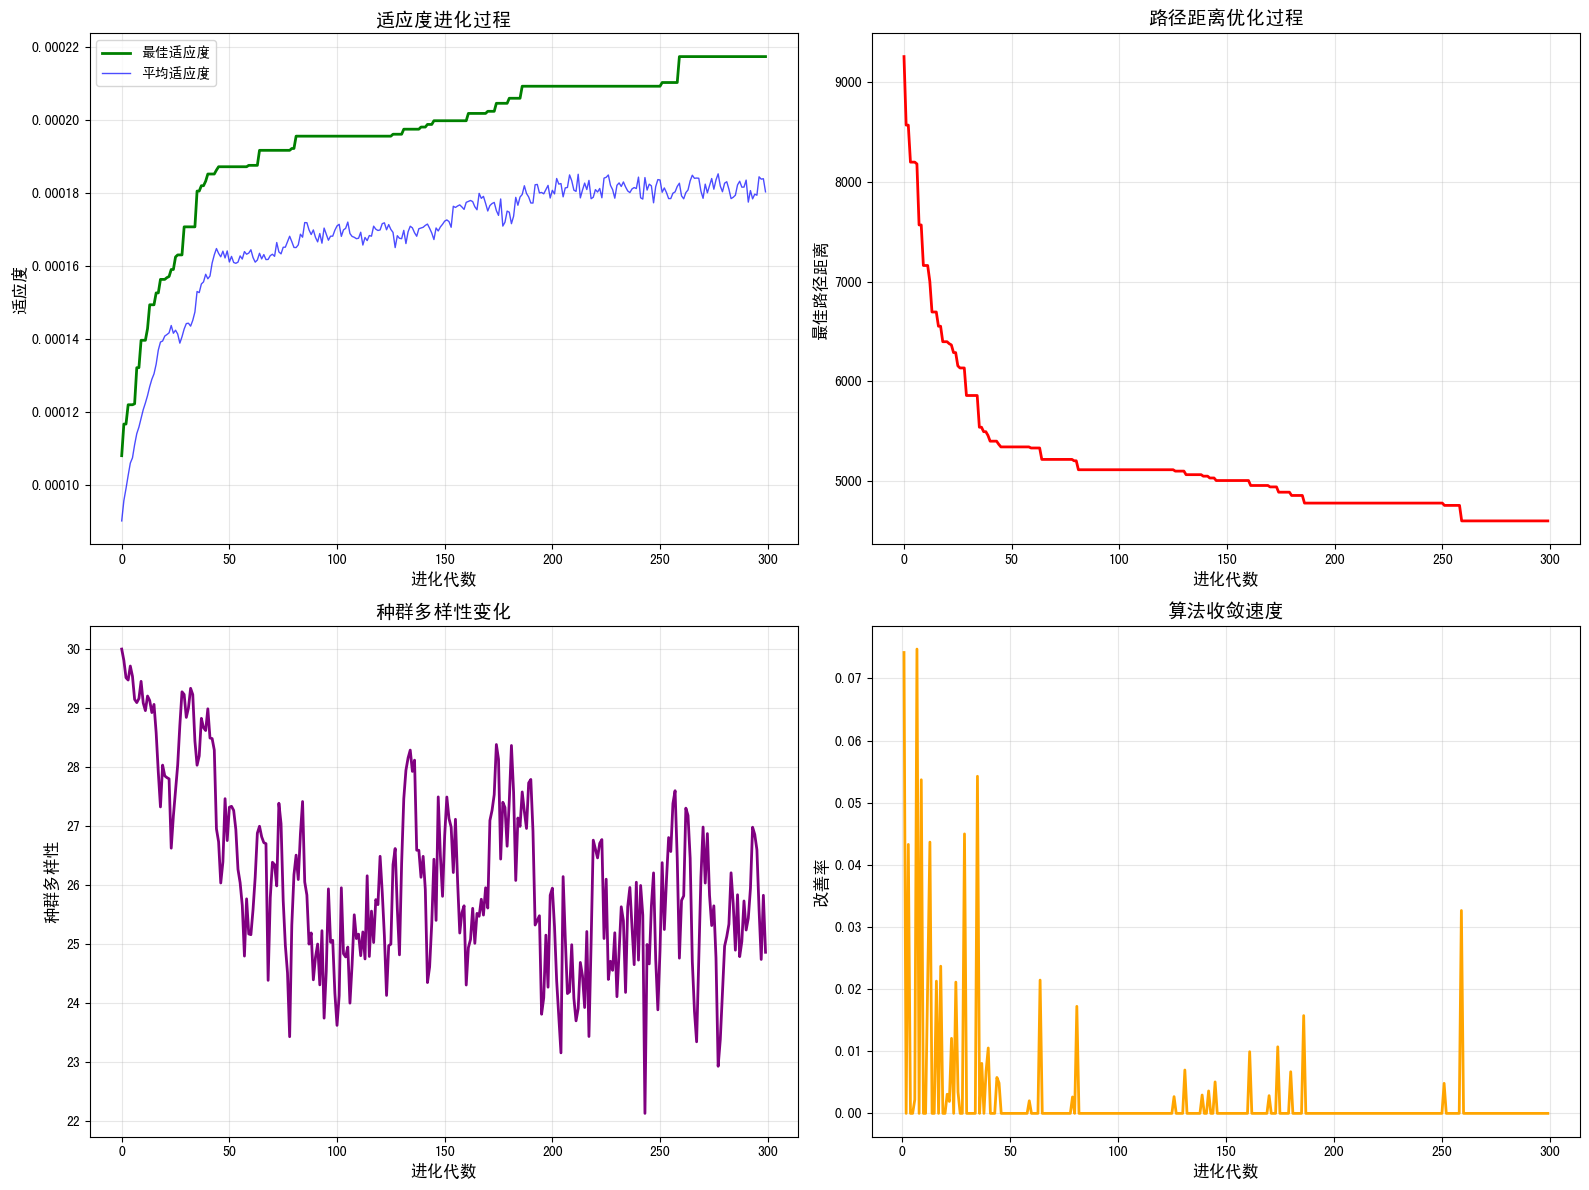

In [4]:
def plot_evolution_process(ga_solver):
    """绘制遗传算法进化过程的可视化图表"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    generations = ga_solver.history['generations']
    best_fitness = ga_solver.history['best_fitness']
    avg_fitness = ga_solver.history['avg_fitness']
    diversity = ga_solver.history['diversity']
    best_distances = ga_solver.history['best_distances']
    
    # 1. 适应度进化曲线
    ax1.plot(generations, best_fitness, 'g-', linewidth=2, label='最佳适应度')
    ax1.plot(generations, avg_fitness, 'b-', linewidth=1, alpha=0.7, label='平均适应度')
    ax1.set_xlabel('进化代数', fontsize=12)
    ax1.set_ylabel('适应度', fontsize=12)
    ax1.set_title('适应度进化过程', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. 距离优化曲线
    ax2.plot(generations, best_distances, 'r-', linewidth=2)
    ax2.set_xlabel('进化代数', fontsize=12)
    ax2.set_ylabel('最佳路径距离', fontsize=12)
    ax2.set_title('路径距离优化过程', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. 种群多样性变化
    ax3.plot(generations, diversity, 'purple', linewidth=2)
    ax3.set_xlabel('进化代数', fontsize=12)
    ax3.set_ylabel('种群多样性', fontsize=12)
    ax3.set_title('种群多样性变化', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. 收敛速度分析
    if len(best_distances) > 1:
        improvement_rate = []
        for i in range(1, len(best_distances)):
            if best_distances[i-1] > 0:
                rate = (best_distances[i-1] - best_distances[i]) / best_distances[i-1]
                improvement_rate.append(max(0, rate))  # 只保留改善的情况
            else:
                improvement_rate.append(0)
        
        ax4.plot(generations[1:], improvement_rate, 'orange', linewidth=2)
        ax4.set_xlabel('进化代数', fontsize=12)
        ax4.set_ylabel('改善率', fontsize=12)
        ax4.set_title('算法收敛速度', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制进化过程
plot_evolution_process(ga_solver)

## 5. 最终路径可视化

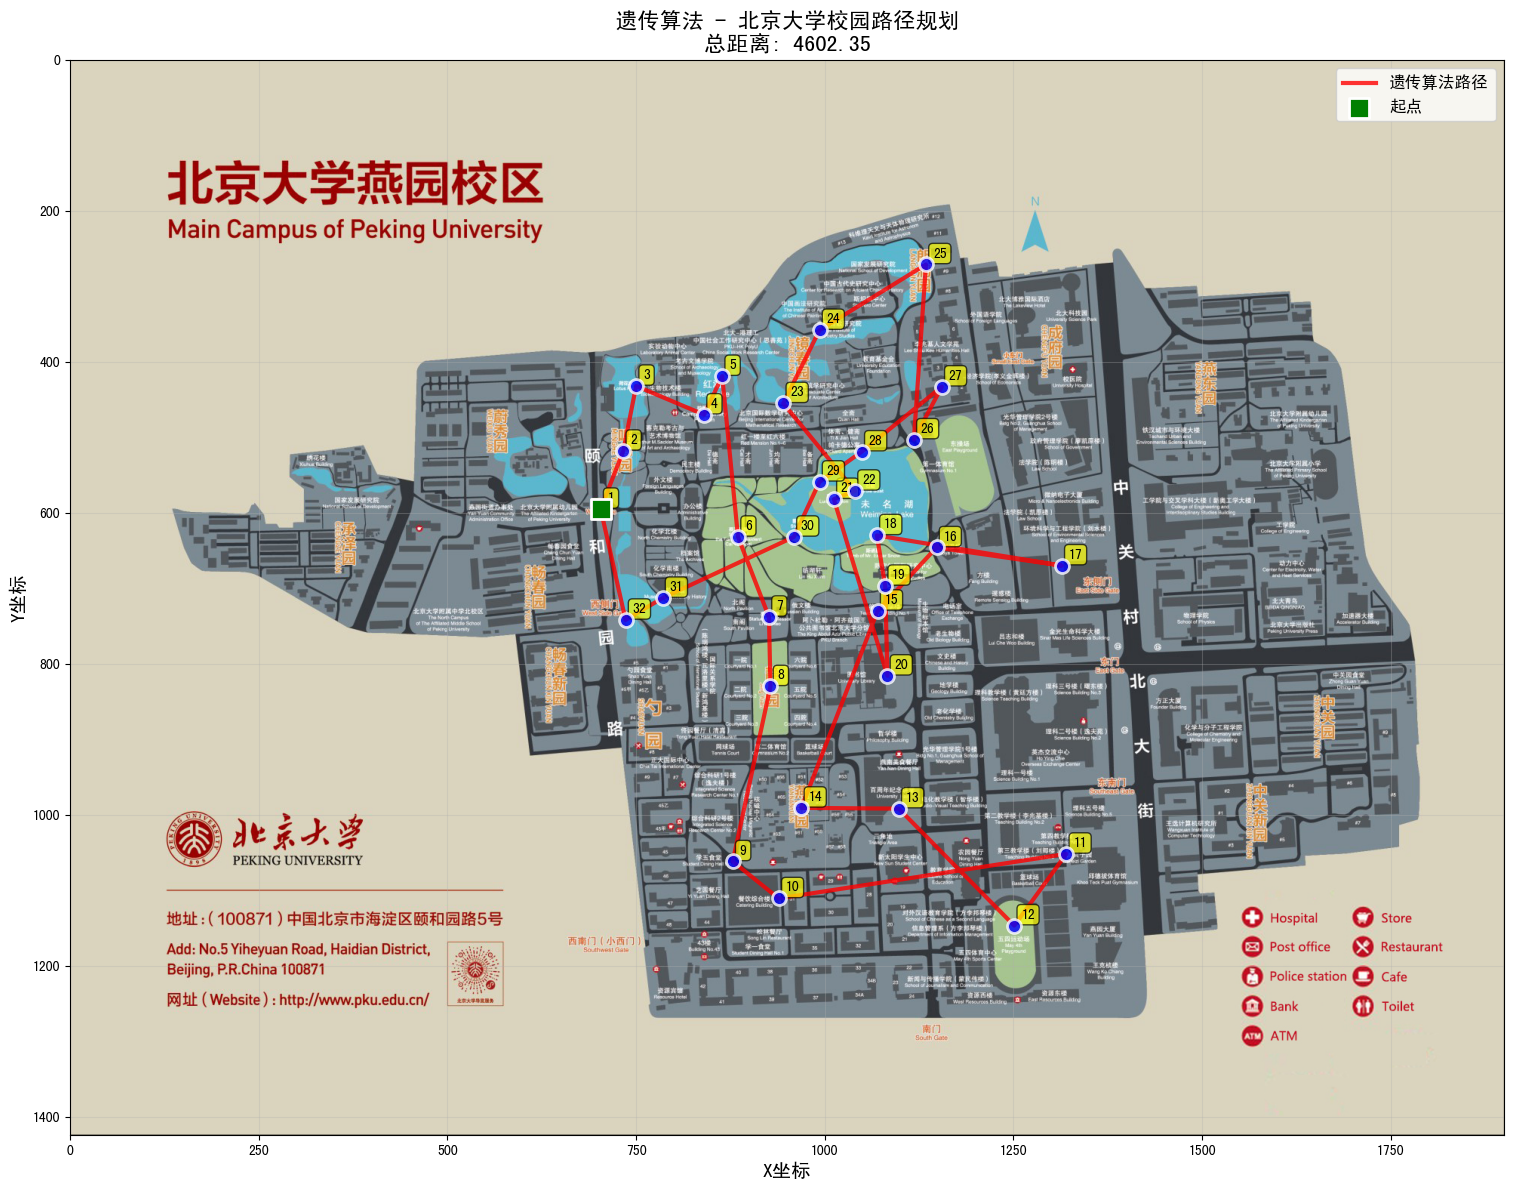

<Figure size 640x480 with 0 Axes>

In [5]:
def plot_tsp_result(ga_solver, path, distance, title):
    """绘制TSP结果"""
    plt.figure(figsize=(16, 12))
    
    # 绘制地图背景
    try:
        campus_map = mpimg.imread(MAP_IMAGE_PATH)
        plt.imshow(campus_map, extent=[0, campus_map.shape[1], campus_map.shape[0], 0])
    except FileNotFoundError:
        print(f"警告: 地图文件 '{MAP_IMAGE_PATH}' 未找到")
        plt.xlim(0, 1500)
        plt.ylim(0, 1200)
        plt.gca().invert_yaxis()
    
    # 绘制路径
    path_coords = ga_solver.city_coords[path + [path[0]]]  # 添加回到起点
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'r-', linewidth=3, alpha=0.8, label='遗传算法路径')
    
    # 绘制城市点
    plt.scatter(ga_solver.city_coords[:, 0], ga_solver.city_coords[:, 1], 
               c='blue', s=100, zorder=5, alpha=0.8, edgecolors='white', linewidth=2)
    
    # 突出显示起点
    start_coord = ga_solver.city_coords[path[0]]
    plt.scatter(start_coord[0], start_coord[1], c='green', s=200, marker='s', 
               zorder=6, label='起点', edgecolors='white', linewidth=2)
    
    # 添加城市编号
    for i, (city_idx, coord) in enumerate(zip(path, ga_solver.city_coords[path])):
        plt.annotate(f'{i+1}', (coord[0], coord[1]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.title(f'{title}\n总距离: {distance:.2f}', fontsize=16, fontweight='bold')
    plt.xlabel('X坐标', fontsize=14)
    plt.ylabel('Y坐标', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()

# 绘制遗传算法结果
fig = plot_tsp_result(ga_solver, ga_path, ga_distance, 
                     '遗传算法 - 北京大学校园路径规划')

## 6. 详细路径分析

In [6]:
def print_detailed_path_analysis(ga_solver, path, distance, algorithm_name):
    """打印详细的路径分析"""
    print(f"\n{'='*80}")
    print(f"🔍 {algorithm_name} - 详细路径分析")
    print(f"{'='*80}")
    
    print(f"\n📍 完整访问路径:")
    total_segments = len(path)
    cumulative_distance = 0
    
    for i in range(total_segments):
        current_city = path[i]
        next_city = path[(i + 1) % total_segments]  # 回到起点
        
        current_name = ga_solver.city_names[current_city]
        next_name = ga_solver.city_names[next_city]
        
        segment_distance = ga_solver.distance_matrix[current_city][next_city]
        cumulative_distance += segment_distance
        
        status = "[回到起点]" if i == total_segments - 1 else ""
        print(f"{i+1:2d}. {current_name:<40} -> {next_name:<40} "
              f"距离: {segment_distance:7.2f} | 累计: {cumulative_distance:8.2f} {status}")
    
    print(f"\n📊 统计信息:")
    segments_distances = [ga_solver.distance_matrix[path[i]][path[(i+1) % len(path)]] 
                         for i in range(len(path))]
    
    print(f"   总访问地点数: {len(path)}")
    print(f"   总路径距离: {distance:.2f}")
    print(f"   平均段距离: {np.mean(segments_distances):.2f}")
    print(f"   最长段距离: {np.max(segments_distances):.2f}")
    print(f"   最短段距离: {np.min(segments_distances):.2f}")
    print(f"   距离标准差: {np.std(segments_distances):.2f}")
    
    # 找出最长和最短的路径段
    max_segment_idx = np.argmax(segments_distances)
    min_segment_idx = np.argmin(segments_distances)
    
    print(f"\n🔗 路径段分析:")
    print(f"   最长路径段: {ga_solver.city_names[path[max_segment_idx]]} -> "
          f"{ga_solver.city_names[path[(max_segment_idx+1) % len(path)]]} ({segments_distances[max_segment_idx]:.2f})")
    print(f"   最短路径段: {ga_solver.city_names[path[min_segment_idx]]} -> "
          f"{ga_solver.city_names[path[(min_segment_idx+1) % len(path)]]} ({segments_distances[min_segment_idx]:.2f})")

# 分析遗传算法结果
print_detailed_path_analysis(ga_solver, ga_path, ga_distance, "遗传算法")


🔍 遗传算法 - 详细路径分析

📍 完整访问路径:
 1. West Gate                                -> MINGHE YUAN                              距离:   82.64 | 累计:    82.64 
 2. MINGHE YUAN                              -> Lotus Pond                               距离:   87.66 | 累计:   170.30 
 3. Lotus Pond                               -> Campus Scenery Pavilion                  距离:   97.69 | 累计:   268.00 
 4. Campus Scenery Pavilion                  -> Red Lake                                 距离:   56.36 | 累计:   324.36 
 5. Red Lake                                 -> Statue of the Former Principal Cai Yuanpei 距离:  214.03 | 累计:   538.39 
 6. Statue of the Former Principal Cai Yuanpei -> Statue of Professor Li Dazhao            距离:  113.65 | 累计:   652.05 
 7. Statue of Professor Li Dazhao            -> Jing Yuan                                距离:   92.02 | 累计:   744.07 
 8. Jing Yuan                                -> Fountain                                 距离:  237.33 | 累计:   981.39 
 9. Fountain                    

## 7. 参数敏感性分析


🔬 遗传算法参数敏感性分析

测试配置: 标准配置
  种群大小: 100, 进化代数: 200
  交叉率: 0.8, 变异率: 0.02
  平均距离: 4659.57 (±368.40)
  最佳距离: 4275.26
  平均时间: 1.925秒

测试配置: 大种群
  种群大小: 150, 进化代数: 150
  交叉率: 0.8, 变异率: 0.02
  平均距离: 4659.57 (±368.40)
  最佳距离: 4275.26
  平均时间: 1.925秒

测试配置: 大种群
  种群大小: 150, 进化代数: 150
  交叉率: 0.8, 变异率: 0.02
  平均距离: 4289.34 (±77.54)
  最佳距离: 4209.68
  平均时间: 2.946秒

测试配置: 高交叉率
  种群大小: 100, 进化代数: 200
  交叉率: 0.9, 变异率: 0.02
  平均距离: 4289.34 (±77.54)
  最佳距离: 4209.68
  平均时间: 2.946秒

测试配置: 高交叉率
  种群大小: 100, 进化代数: 200
  交叉率: 0.9, 变异率: 0.02
  平均距离: 4363.70 (±163.00)
  最佳距离: 4173.88
  平均时间: 1.961秒

测试配置: 高变异率
  种群大小: 100, 进化代数: 200
  交叉率: 0.8, 变异率: 0.05
  平均距离: 4363.70 (±163.00)
  最佳距离: 4173.88
  平均时间: 1.961秒

测试配置: 高变异率
  种群大小: 100, 进化代数: 200
  交叉率: 0.8, 变异率: 0.05
  平均距离: 4482.43 (±87.45)
  最佳距离: 4413.80
  平均时间: 1.929秒

测试配置: 长进化
  种群大小: 80, 进化代数: 300
  交叉率: 0.8, 变异率: 0.02
  平均距离: 4482.43 (±87.45)
  最佳距离: 4413.80
  平均时间: 1.929秒

测试配置: 长进化
  种群大小: 80, 进化代数: 300
  交叉率: 0.8, 变异率: 0.02
  平均距离: 4462.24 (±33.08)
 

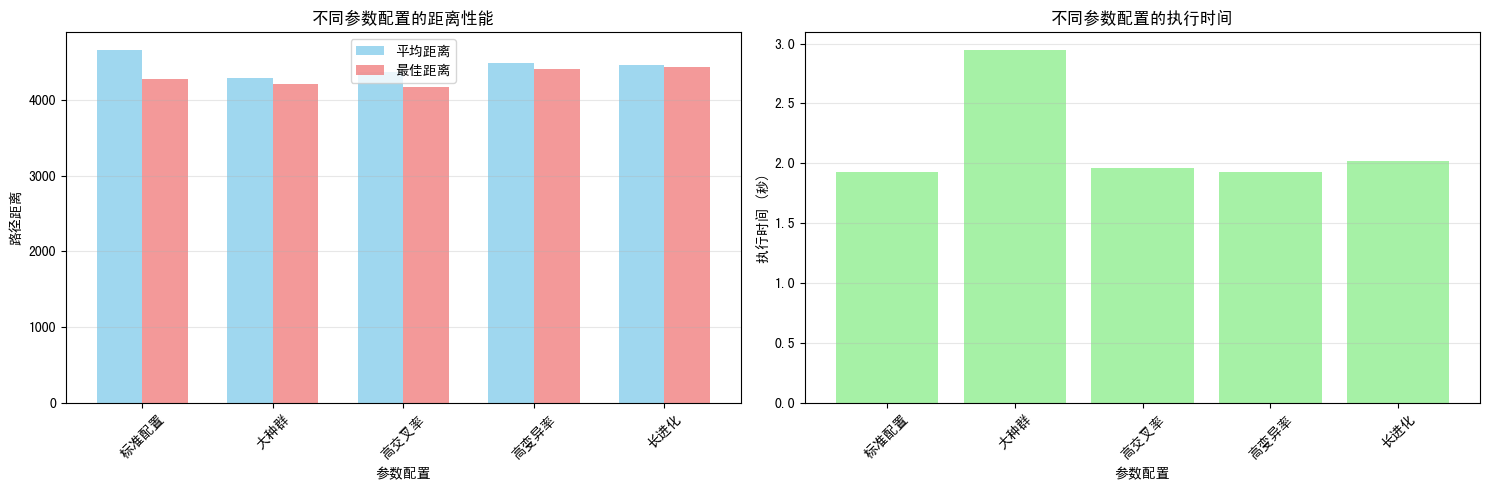


🏆 分析结果:
  最佳质量配置: 高交叉率 (距离: 4173.88)
  最快执行配置: 标准配置 (时间: 1.925秒)


In [7]:
def parameter_sensitivity_analysis(ga_solver, start_city_index):
    """进行参数敏感性分析"""
    print("\n" + "="*100)
    print("🔬 遗传算法参数敏感性分析")
    print("="*100)
    
    # 测试不同的参数组合
    parameter_configs = [
        {"name": "标准配置", "pop_size": 100, "generations": 200, "crossover": 0.8, "mutation": 0.02},
        {"name": "大种群", "pop_size": 150, "generations": 150, "crossover": 0.8, "mutation": 0.02},
        {"name": "高交叉率", "pop_size": 100, "generations": 200, "crossover": 0.9, "mutation": 0.02},
        {"name": "高变异率", "pop_size": 100, "generations": 200, "crossover": 0.8, "mutation": 0.05},
        {"name": "长进化", "pop_size": 80, "generations": 300, "crossover": 0.8, "mutation": 0.02}
    ]
    
    results = []
    
    for config in parameter_configs:
        print(f"\n测试配置: {config['name']}")
        print(f"  种群大小: {config['pop_size']}, 进化代数: {config['generations']}")
        print(f"  交叉率: {config['crossover']}, 变异率: {config['mutation']}")
        
        # 运行多次取平均
        distances = []
        times = []
        
        for run in range(3):  # 每个配置运行3次
            path, distance, exec_time = ga_solver.genetic_algorithm(
                population_size=config['pop_size'],
                generations=config['generations'],
                crossover_rate=config['crossover'],
                mutation_rate=config['mutation'],
                start_city=start_city_index,
                verbose=False
            )
            distances.append(distance)
            times.append(exec_time)
        
        avg_distance = np.mean(distances)
        std_distance = np.std(distances)
        avg_time = np.mean(times)
        best_distance = min(distances)
        
        results.append({
            'config': config['name'],
            'avg_distance': avg_distance,
            'std_distance': std_distance,
            'best_distance': best_distance,
            'avg_time': avg_time
        })
        
        print(f"  平均距离: {avg_distance:.2f} (±{std_distance:.2f})")
        print(f"  最佳距离: {best_distance:.2f}")
        print(f"  平均时间: {avg_time:.3f}秒")
    
    # 绘制结果对比
    plt.figure(figsize=(15, 5))
    
    configs = [r['config'] for r in results]
    avg_distances = [r['avg_distance'] for r in results]
    best_distances = [r['best_distance'] for r in results]
    times = [r['avg_time'] for r in results]
    
    # 距离对比
    plt.subplot(1, 2, 1)
    x = np.arange(len(configs))
    width = 0.35
    
    plt.bar(x - width/2, avg_distances, width, label='平均距离', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, best_distances, width, label='最佳距离', alpha=0.8, color='lightcoral')
    
    plt.xlabel('参数配置')
    plt.ylabel('路径距离')
    plt.title('不同参数配置的距离性能')
    plt.xticks(x, configs, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 时间对比
    plt.subplot(1, 2, 2)
    plt.bar(configs, times, alpha=0.8, color='lightgreen')
    plt.xlabel('参数配置')
    plt.ylabel('执行时间 (秒)')
    plt.title('不同参数配置的执行时间')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 找出最佳配置
    best_config = min(results, key=lambda x: x['best_distance'])
    fastest_config = min(results, key=lambda x: x['avg_time'])
    
    print(f"\n🏆 分析结果:")
    print(f"  最佳质量配置: {best_config['config']} (距离: {best_config['best_distance']:.2f})")
    print(f"  最快执行配置: {fastest_config['config']} (时间: {fastest_config['avg_time']:.3f}秒)")
    
    return results

# 运行参数敏感性分析
sensitivity_results = parameter_sensitivity_analysis(ga_solver, start_city_index)

## 8. 算法性能总结与对比

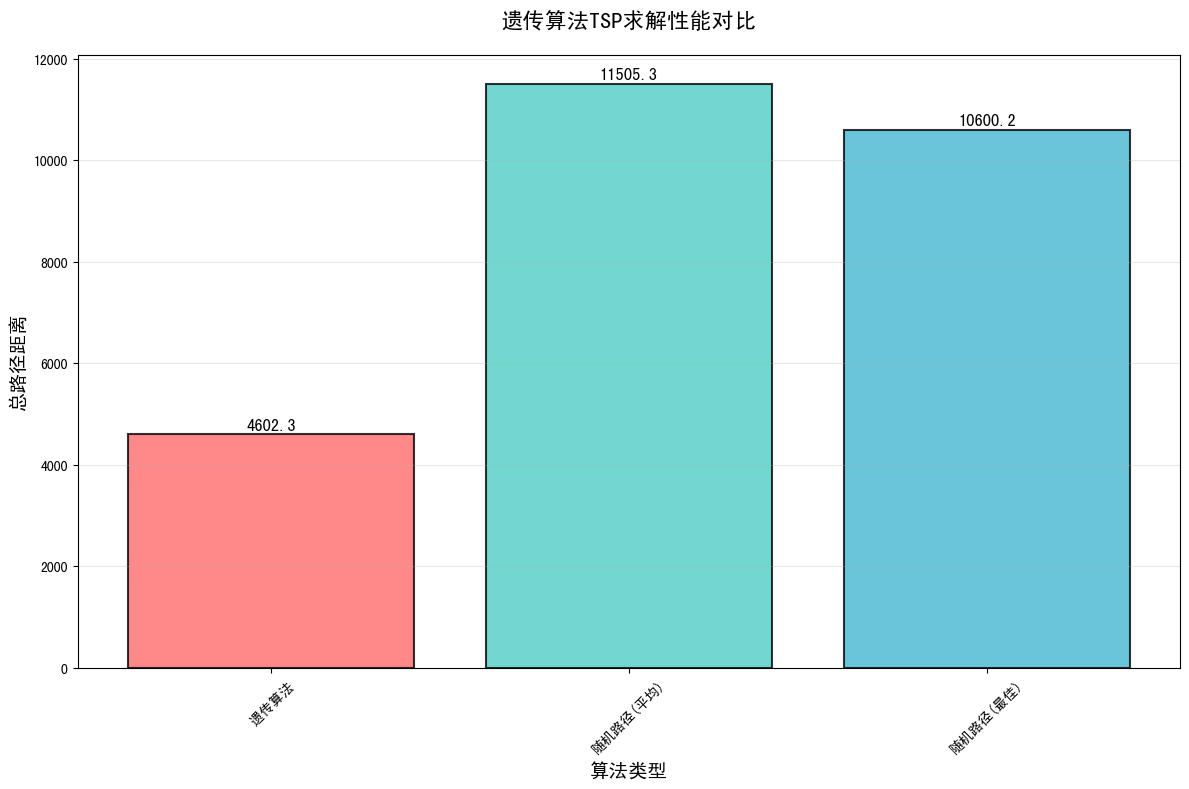


🎯 遗传算法TSP求解 - 最终总结

🏛️ 问题规模:
   北京大学校园地点数: 32
   起始地点: West Gate
   问题复杂度: O(n!) = O(32!) ≈ 2.63e+35

🚀 算法性能:
   遗传算法: 4602.35 (执行时间: 2.913秒)
   随机解平均性能: 11505.31
   随机解最佳性能: 10600.21

🏆 优化效果:
   相比随机解平均改善: 60.0%
   相比随机解最佳改善: 56.6%

🧬 算法特点:
   ✓ 全局搜索能力: 通过交叉和变异操作探索解空间
   ✓ 种群进化: 多个体并行搜索，增强搜索效率
   ✓ 自适应优化: 精英保留策略保证解质量不退化
   ✓ 参数可调: 可根据问题特点调整种群、交叉、变异参数
   ✗ 参数敏感: 性能高度依赖参数选择
   ✗ 收敛较慢: 需要较多代数才能收敛到稳定解

🔬 算法机制:
   • 编码方式: 城市序列染色体
   • 选择策略: 锦标赛选择
   • 交叉算子: 顺序交叉(OX)
   • 变异操作: 交换变异 + 插入变异
   • 总进化代数: 300

📈 进化分析:
   初代最优解: 10159.52
   最终最优解: 4445.10
   进化改善: 56.2%
   最终种群多样性: 25.23

🎨 可视化输出:
   ✓ 完整的进化过程动态图
   ✓ 适应度、多样性、收敛速度分析
   ✓ 最优路径地图可视化
   ✓ 参数敏感性分析结果

🌟 遗传算法成功应用于北京大学校园TSP问题求解！
程序执行完成！


In [8]:
# 创建最终性能对比图
plt.figure(figsize=(12, 8))

# 算法名称和对应距离
algorithms = ['遗传算法', '随机路径(平均)', '随机路径(最佳)']
distances = [ga_distance, avg_random_distance, best_random_distance]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = plt.bar(algorithms, distances, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# 在柱状图上添加数值标签
for bar, distance in zip(bars, distances):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{distance:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title('遗传算法TSP求解性能对比', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('总路径距离', fontsize=14)
plt.xlabel('算法类型', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 打印最终总结
print("\n" + "="*100)
print("🎯 遗传算法TSP求解 - 最终总结")
print("="*100)

print(f"\n🏛️ 问题规模:")
print(f"   北京大学校园地点数: {len(CITIES)}")
print(f"   起始地点: {start_city_name}")
print(f"   问题复杂度: O(n!) = O({len(CITIES)}!) ≈ {np.math.factorial(len(CITIES)):.2e}")

print(f"\n🚀 算法性能:")
print(f"   遗传算法: {ga_distance:.2f} (执行时间: {ga_time:.3f}秒)")
print(f"   随机解平均性能: {avg_random_distance:.2f}")
print(f"   随机解最佳性能: {best_random_distance:.2f}")

print(f"\n🏆 优化效果:")
print(f"   相比随机解平均改善: {ga_improvement:.1f}%")
if ga_distance < best_random_distance:
    print(f"   相比随机解最佳改善: {(best_random_distance - ga_distance) / best_random_distance * 100:.1f}%")

print(f"\n🧬 算法特点:")
print(f"   ✓ 全局搜索能力: 通过交叉和变异操作探索解空间")
print(f"   ✓ 种群进化: 多个体并行搜索，增强搜索效率")
print(f"   ✓ 自适应优化: 精英保留策略保证解质量不退化")
print(f"   ✓ 参数可调: 可根据问题特点调整种群、交叉、变异参数")
print(f"   ✗ 参数敏感: 性能高度依赖参数选择")
print(f"   ✗ 收敛较慢: 需要较多代数才能收敛到稳定解")

print(f"\n🔬 算法机制:")
print(f"   • 编码方式: 城市序列染色体")
print(f"   • 选择策略: 锦标赛选择")
print(f"   • 交叉算子: 顺序交叉(OX)")
print(f"   • 变异操作: 交换变异 + 插入变异")
print(f"   • 总进化代数: {len(ga_solver.history['generations'])}")

print(f"\n📈 进化分析:")
if ga_solver.history['best_distances']:
    initial_best = ga_solver.history['best_distances'][0]
    final_best = ga_solver.history['best_distances'][-1]
    improvement = (initial_best - final_best) / initial_best * 100
    print(f"   初代最优解: {initial_best:.2f}")
    print(f"   最终最优解: {final_best:.2f}")
    print(f"   进化改善: {improvement:.1f}%")
    
    # 分析收敛特性
    final_diversity = ga_solver.history['diversity'][-1] if ga_solver.history['diversity'] else 0
    print(f"   最终种群多样性: {final_diversity:.2f}")

print(f"\n🎨 可视化输出:")
print(f"   ✓ 完整的进化过程动态图")
print(f"   ✓ 适应度、多样性、收敛速度分析")
print(f"   ✓ 最优路径地图可视化")
print(f"   ✓ 参数敏感性分析结果")

print("\n" + "="*100)
print("🌟 遗传算法成功应用于北京大学校园TSP问题求解！")
print("程序执行完成！")
print("="*100)